# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

#!pip install pyLDAvis

In [ ]:
# These libraries may be useful to you

import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('brown')
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [ ]:
# add any additional libaries you need here
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:
# This function comes from the BTAP repo.
def display_topics(model, features, no_top_words=5, transformed_cell=None, preprocessing_exc_tuple=None):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1]  # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]] * 100.0 / total)))


## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [ ]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [ ]:
categories = ['editorial','government','news','romance','hobbies']

category_list = []
file_ids = []
texts = []

for category in categories :
    for file_id in brown.fileids(categories=category) :

        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)

        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))



df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts

df.shape

(166, 3)

In [ ]:
df['category'].head

<bound method NDFrame.head of 0      editorial
1      editorial
2      editorial
3      editorial
4      editorial
         ...    
161      hobbies
162      hobbies
163      hobbies
164      hobbies
165      hobbies
Name: category, Length: 166, dtype: object>

In [ ]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

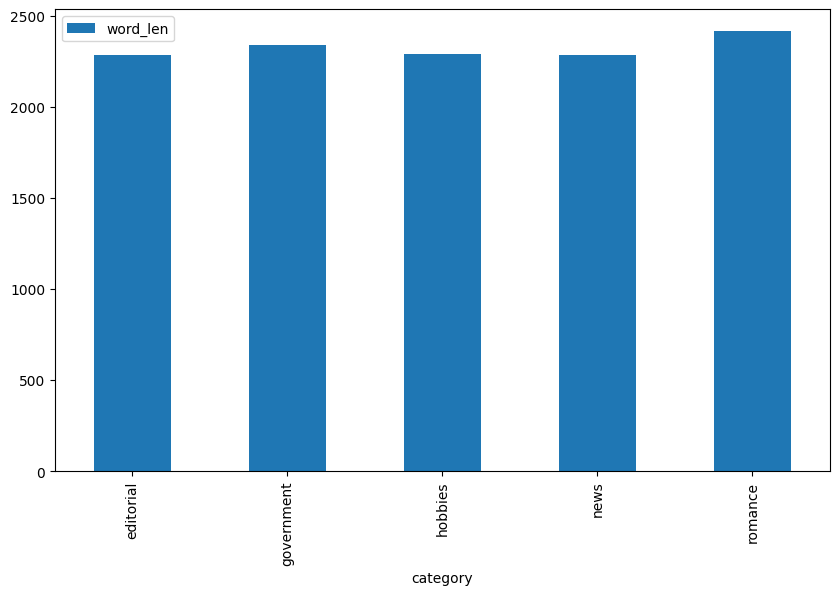

In [ ]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [ ]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape


(166, 4941)

In [ ]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold?

A: count_text_vectors is a matrix that holds documents as rows, and the words as columns. Each time a word is found it counts the number in the column. If the word find is in the rows (document) 10 times, it will appear as 10 under the columnd "find".

the tfidf_text_vector is a matrix as well but instead of using the count it uses the importance of the word in the corpus. If the word occurs frequently in the document but rarely in the dataset it will have a high tfidf score.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections.

In [ ]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [ ]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results.


In [ ]:
# Find each document's topic with the highest strength.
predicted_topics = np.argmax(W_text_matrix, axis=1) # predicted_topics will be an index with all the predicted topics for each document.

topic_to_category_mapping = { # my guesses on the topics based on the top words.
    0: 'government',
    1: 'romance',
    2: 'news',
    3: 'editorial',
    4: 'hobbies',
}


predicted_topics = np.argmax(W_text_matrix, axis=1)

# Map predicted topics to corresponding descriptive category names
predicted_categories = [topic_to_category_mapping[topic_idx] for topic_idx in predicted_topics]

original_categories = df['category']

# Compare predicted categories with original categories
correct_predictions = (predicted_categories == original_categories)

# Calculate accuracy
accuracy = sum(correct_predictions) / len(correct_predictions)
print(f"Accuracy: {accuracy:.2f}")




Accuracy: 0.27


Q: How does your five-topic NMF model compare to the original Brown categories?

A: This does not produce a higher accuracy to the original topics. A few observations I made the CountVectorizer is trying to tokenize "ll" and "ve" which are clearly contractions and per the stop words should be dropped. I am not sure why they do not get dropped and why they are kept in but that is certainly causing problems. Topic 01 and Topic 03 provide little to no insight. I noticed the notebook did not call for preprocessing of the data which is an issue in my opinion because countvectorizer is clearly trying to tokenize in a manner than is not consisten with the stop words.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above.

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results.


In [ ]:
svd_text_model = TruncatedSVD(n_components=5, random_state=314)
W_text_matrix_svd = svd_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix_svd = svd_text_model.components_

In [ ]:

topic_to_category_mapping_svd = { # my guesses on the topics based on the top words.
    0: 'editorial',
    1: 'romance',
    2: 'news',
    3: 'hobbies',
    4: 'sports',
}


predicted_topics_svd = np.argmax(W_text_matrix_svd, axis=1)

# Map predicted topics to corresponding descriptive category names
predicted_categories_svd = [topic_to_category_mapping_svd[topic_idx] for topic_idx in predicted_topics_svd]

# Compare predicted categories with original categories
correct_predictions_svd = (predicted_categories_svd == original_categories)

# Calculate accuracy
accuracy_svd = sum(correct_predictions_svd) / len(correct_predictions_svd)
print(f"Accuracy: {accuracy_svd:.2f}")


Accuracy: 0.21


Q: How does your five-topic LSA model compare to the original Brown categories?

A: This method still produces a very low accuracy score. I still believe this is a preprocessing issue and preprocesing should not be left to the tf-idf nor the count vectorizer because there are issues.  

In [ ]:
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output?

A: There is not much to go off of in top 00 topic 01, or topic 02. So I did the best I could based on what the top topics were. COuld be news, government, or an editorial based on the Titles used. The word said is also mentioned alot so I assumed it had to be reporting of some kind.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization.

In [ ]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=30)

lda_topic_matrix = lda_model.fit_transform(count_text_vectors)

In [ ]:
display_topics(lda_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.54)
  little (0.52)
  old (0.52)
  man (0.49)
  good (0.47)

Topic 01
  states (0.89)
  united (0.82)
  government (0.80)
  state (0.67)
  general (0.56)

Topic 02
  state (0.86)
  000 (0.62)
  mr (0.47)
  company (0.39)
  said (0.39)

Topic 03
  mrs (0.64)
  service (0.38)
  work (0.36)
  use (0.35)
  area (0.34)

Topic 04
  world (0.64)
  president (0.58)
  american (0.57)
  peace (0.56)
  kennedy (0.52)


Q: What inference do you draw from the displayed topics for your LDA model?

A: I actually really felt that this model performed the best. The topics make sense, they are words that appear to be meaningful and not just filler. They seem to be able to represent an actual topic. Just looking over them I can tell topic 4 is definitely news/government, same as Topic 01. Topic 00 could be fiction. etc. It worked much better than both of the other methods used above.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?

A: Unfortunately I do not notice much of a different in accuracy for the LDA model in comparison to the other models' accuracy scores, which is dissapointing. I did believe that the topics were more reflective in this model, so I need to figure out the disconnect. My main idea is that the preprocessing is still the main issue.

In [ ]:
topic_to_category_mapping_LDA = { # my guesses on the topics based on the top words.
    0: 'editorial',
    1: 'government',
    2: 'news',
    3: 'news',
    4: 'government',
}

topics_LDA = [np.argmax(topic_probs) for topic_probs in lda_topic_matrix]

# Map predicted topics to corresponding descriptive category names
predicted_categories_LDA = [topic_to_category_mapping_LDA[topic_idx] for topic_idx in topics_LDA]

# Compare predicted categories with original categories
correct_predictions_LDA = (predicted_categories_LDA == original_categories)

# Calculate accuracy
accuracy_LDA = sum(correct_predictions_LDA) / len(correct_predictions_LDA)
print(f"Accuracy: {accuracy_LDA:.2f}")

Accuracy: 0.22


In [ ]:
lda_display = pyLDAvis.lda_model.prepare(lda_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [ ]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: I think said is definitely a word that needs to be removed. Along it the contractions that were not properly removed. I think got could be removed as well. Otherwise I think this is very representative of some of the categories in the brown data set. Specifically related to News, Government, editorials.

Speaking on the intertopic distance map, it appears that categories 3/4 have overlap and the remaining categories have distinct topics. Topics, 1, 5, and 2 are almost completely on opposite sides of one another. The model may be struggle to differentiate between 3/4 which could be the reason for the overlap.